In [1]:
"""
Created on Wed Jan 10 17:13:16 2024
@author: Wu Yuxuan
"""

import os
import warnings

from gseapy import Msigdb
import decoupler as dc
import gseapy as gp
from gseapy import barplot, dotplot
import scFates as scf
import pandas as pd
import anndata as ad
import scanpy as sc
import seaborn as sns
import numpy as np
from matplotlib import rc_context
from adjustText import adjust_text
from matplotlib import pyplot as plt
from ridgeplot import ridgeplot

import cellrank as cr
# import scanpy as sc
import scvelo as scv

from statannotations.Annotator import Annotator

In [2]:
seed = 1
warnings.simplefilter(action='ignore', category=FutureWarning)
# info
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(vector_friendly=True, dpi_save=1200) 
sc.logging.print_header()

scanpy==0.1.dev3254+g5b9bc72 anndata==0.10.3 umap==0.5.5 numpy==1.26.0 scipy==1.11.3 pandas==1.5.2 scikit-learn==1.1.3 statsmodels==0.14.0 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.11


In [3]:
os.chdir('/home/wu/datb1/reseq_ppp/Pub_PPP_code')

In [4]:
sns.set_style("white")

In [5]:
adata_ker = ad.read_h5ad('/home/wu/datb1/reseq_ppp/processed_data/KC_PPP_10X.h5ad')

In [6]:
adata_ker.obs['batch_group'] = adata_ker.obs.batch_group.cat.reorder_categories(['HC', 'NL', 'Lesion'])
adata_ker.uns['batch_group_colors'] = ['#3182bd', '#31a354', '#fd8d3c']

df_name = adata_ker.obs['batch'].astype(str).str.split("_", expand=True)
df_name.loc[df_name.index.str.contains('PPP'), 1] = df_name.loc[df_name.index.str.contains('PPP'), 1].str.split("C", expand=True)[0]
df_name = df_name[0] + '_' + df_name[1]
# df_name.str.split("C", expand=True)[0]
# df_name[df_name.index.str.contains('PPP_')] = df_name[df_name.index.str.contains('PPP')].str.split("C", expand=True)[0]
adata_ker.obs['patient'] = df_name.copy()
adata_ker.obs['patient'].value_counts()

adata_ker.obs['leiden'] = adata_ker.obs['leiden'].cat.reorder_categories(['Basal KC I', 'Basal KC II', 'Basal KC III', 'Suprabasal KC I', 
                                            'Suprabasal KC II', 'Proliferating KC', 'Stressed KC'])

def map_cell_type(leiden):
    if "Suprabasal" in leiden:
        return "Suprabasal"
    elif "Basal" in leiden:
        return "Basal"
    elif "Stressed" in leiden:
        return "Stressed"
    elif "Proliferating" in leiden:
        return "Proliferating"
    else:
        assert False, f"Unknown cell type: {leiden}"

adata_ker.obs['cell_type'] = adata_ker.obs['leiden'].apply(map_cell_type)
adata_ker.obs['meta_cell_type'] = adata_ker.obs['Meta'].astype(str) + '_' + adata_ker.obs['cell_type'].astype(str)
adata_ker.obs['batch_group_cell_type'] = adata_ker.obs['batch_group'].astype(str) + '_' + adata_ker.obs['cell_type'].astype(str)

### DE between supra II and supra I

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:17)


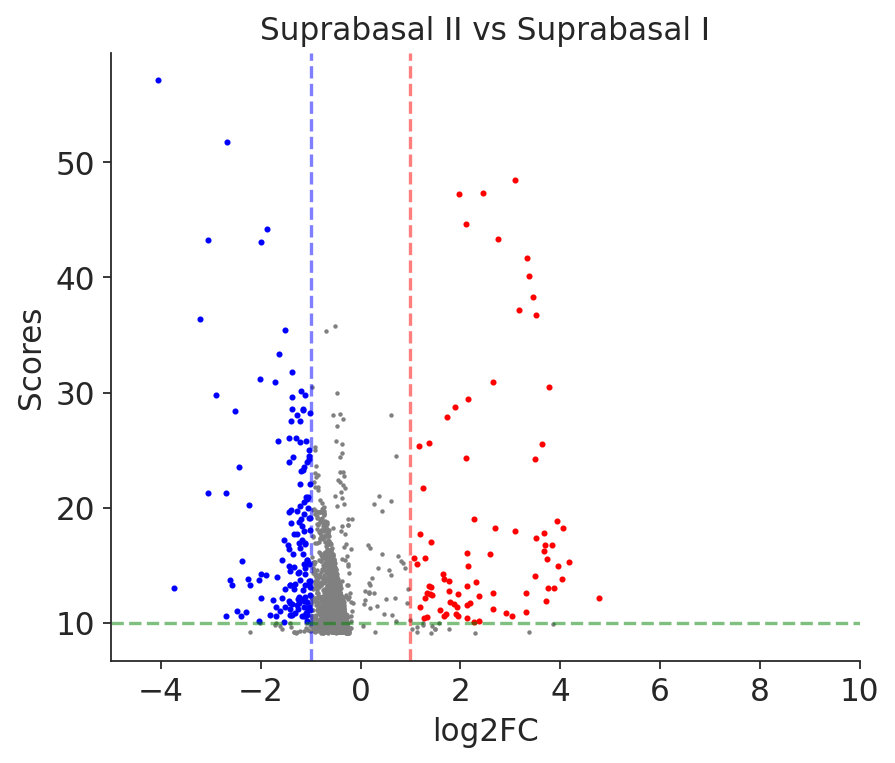

In [15]:
sc.tl.rank_genes_groups(adata_ker, 'leiden', method='wilcoxon', n_genes=2000, use_raw=True, groups=['Suprabasal KC II'], reference='Suprabasal KC I', rankby_abs=True, tie_correct=True)
double_gene_rank_df = sc.get.rank_genes_groups_df(adata_ker, group='Suprabasal KC II', key='rank_genes_groups',pval_cutoff=0.01)
double_gene_rank_df['scores'] = np.abs(double_gene_rank_df['scores'])

with rc_context({'figure.figsize': (6, 5)}):
    ax = plt.gca()
    plt.scatter(x=double_gene_rank_df['logfoldchanges'],y=double_gene_rank_df['scores'], s=1, color='grey')
    plt.xlim(-5,10)

    # down = df[(df['logFC']<=-2)&(df['adj.P.Val']<=0.01)]
    # up = df[(df['logFC']>=2)&(df['adj.P.Val']<=0.01)]

    # plt.scatter(x=down['logFC'],y=down['adj.P.Val'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
    # plt.scatter(x=up['logFC'],y=up['adj.P.Val'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")

    down = double_gene_rank_df[(double_gene_rank_df['logfoldchanges']<=-1)&(double_gene_rank_df['scores']>=10)]
    up = double_gene_rank_df[(double_gene_rank_df['logfoldchanges']>=1)&(double_gene_rank_df['scores']>=10)]

    plt.scatter(x=down['logfoldchanges'],y=down['scores'],s=3,label="Down-regulated",color="blue")
    plt.scatter(x=up['logfoldchanges'],y=up['scores'],s=3,label="Up-regulated",color="red")

    genes_to_plot = ['S100A8', 'S100A9', 'KRT6A', 'S100A7', 'CXCL8', 'SOD2', 'S100A2',
                    'KRT6B', 'KRT17', 'KRT6C', 'IFI27', 'IFITM3', 'AREG', 'KRT5', 'KRT14',
                    # down
                    'PDLIM4', 'KRT9', 'CCND1', 'KRT1', 'DSC1', 'DMKN']
                    
    texts=[]

    # for i,r in up.iterrows():
    #     if r['logfoldchanges'] < 10 and r['names'] in genes_to_plot:
    #         # print(r['logfoldchanges'],r['scores'],r['names'])
    #         texts.append(plt.text(r['logfoldchanges'],r['scores'],r['names'],fontsize=10, color='black'))

    # for i,r in down.iterrows():
    #     if r['logfoldchanges'] > -10 and r['names'] in genes_to_plot:
    #         # print(r['logfoldchanges'],r['scores'],r['names'])
    #         texts.append(plt.text(r['logfoldchanges'],r['scores'],r['names'],fontsize=10, color='black'))
            
    ax.yaxis.set_ticks_position('left') 
    ax.xaxis.set_ticks_position('bottom')
            
    adjust_text(texts,arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
    sns.despine()
    plt.xlabel("log2FC")
    plt.ylabel("Scores")
    plt.axvline(x=1, color='r', linestyle='--', alpha=0.5)
    plt.axvline(x=-1, color='b', linestyle='--', alpha=0.5)
    plt.axhline(y=10, color='g', linestyle='--', alpha=0.5)
    plt.title("Suprabasal II vs Suprabasal I")
    plt.savefig('figures/fig2_5/Suprabasal_II_vs_I.pdf', bbox_inches='tight')

### Lesion vs Control

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:53)


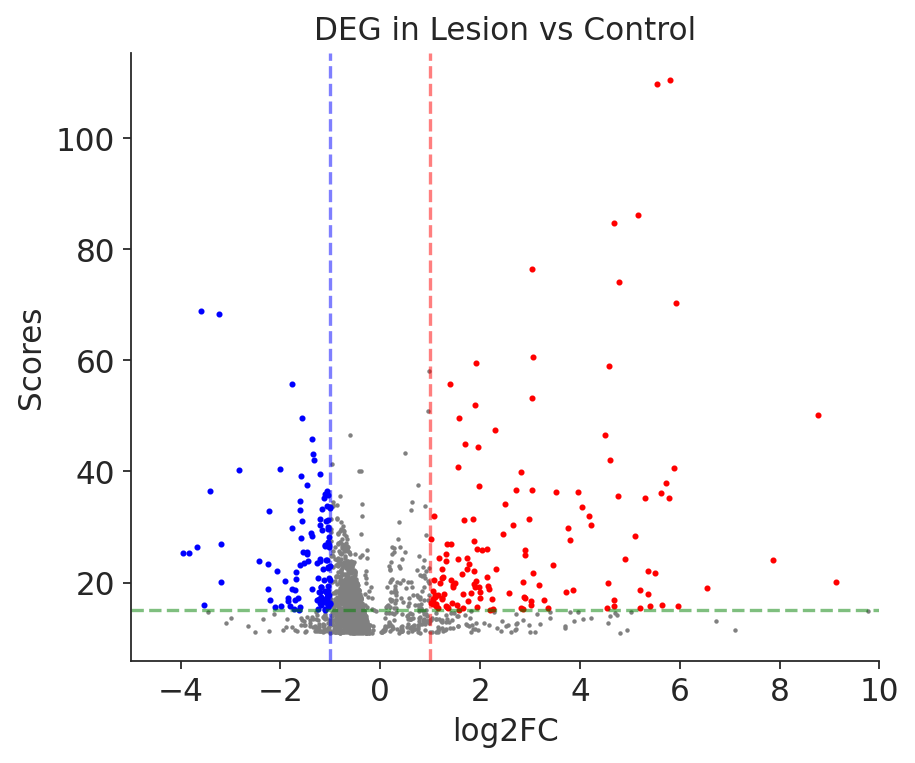

In [17]:
sc.tl.rank_genes_groups(adata_ker, 'Meta', method='wilcoxon', n_genes=2000, use_raw=True, groups=['Lesion'], reference='Control', rankby_abs=True, tie_correct=True)
double_gene_rank_df = sc.get.rank_genes_groups_df(adata_ker, group='Lesion', key='rank_genes_groups',pval_cutoff=0.01)
double_gene_rank_df['scores'] = np.abs(double_gene_rank_df['scores'])

with rc_context({'figure.figsize': (6, 5)}):
    ax = plt.gca()
    plt.scatter(x=double_gene_rank_df['logfoldchanges'],y=double_gene_rank_df['scores'], s=1, color='grey')
    plt.xlim(-5,10)

    # down = df[(df['logFC']<=-2)&(df['adj.P.Val']<=0.01)]
    # up = df[(df['logFC']>=2)&(df['adj.P.Val']<=0.01)]

    # plt.scatter(x=down['logFC'],y=down['adj.P.Val'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
    # plt.scatter(x=up['logFC'],y=up['adj.P.Val'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")

    down = double_gene_rank_df[(double_gene_rank_df['logfoldchanges']<=-1)&(double_gene_rank_df['scores']>=15)]
    up = double_gene_rank_df[(double_gene_rank_df['logfoldchanges']>=1)&(double_gene_rank_df['scores']>=15)]

    plt.scatter(x=down['logfoldchanges'],y=down['scores'],s=3,label="Down-regulated",color="blue")
    plt.scatter(x=up['logfoldchanges'],y=up['scores'],s=3,label="Up-regulated",color="red")

    genes_to_plot = ['S100A8', 'S100A9', 'KRT6A', 'S100A7', 'CXCL8', 'SOD2', 'S100A2',
                    'KRT6B', 'KRT17', 'KRT6C', 'IFI27', 'IFITM3', 'AREG', 'KRT5', 'KRT14',
                    # down
                    'PDLIM4', 'KRT9', 'CCND1', 'KRT1', 'DSC1', 'DMKN']
                    
    texts=[]

    # for i,r in up.iterrows():
    #     if r['logfoldchanges'] < 10 and r['names'] in genes_to_plot:
    #         # print(r['logfoldchanges'],r['scores'],r['names'])
    #         texts.append(plt.text(r['logfoldchanges'],r['scores'],r['names'],fontsize=10, color='black'))

    # for i,r in down.iterrows():
    #     if r['logfoldchanges'] > -10 and r['names'] in genes_to_plot:
    #         # print(r['logfoldchanges'],r['scores'],r['names'])
    #         texts.append(plt.text(r['logfoldchanges'],r['scores'],r['names'],fontsize=10, color='black'))
            
    ax.yaxis.set_ticks_position('left') 
    ax.xaxis.set_ticks_position('bottom')
    sns.despine()            
    adjust_text(texts,arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

    plt.xlabel("log2FC")
    plt.ylabel("Scores")
    plt.axvline(x=1, color='r', linestyle='--', alpha=0.5)
    plt.axvline(x=-1, color='b', linestyle='--', alpha=0.5)
    plt.axhline(y=15, color='g', linestyle='--', alpha=0.5)
    plt.title("DEG in Lesion vs Control")
    plt.savefig("figures/fig2_5/Lesion_vs_Control.pdf", bbox_inches='tight')

### Hallmark enrichment

In [18]:
msig = Msigdb()
gmt_go_bp = msig.get_gmt(category="c5.go.bp", dbver='2023.2.Hs')
gmt_hallmark = msig.get_gmt(category="h.all", dbver='2023.2.Hs')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:46)


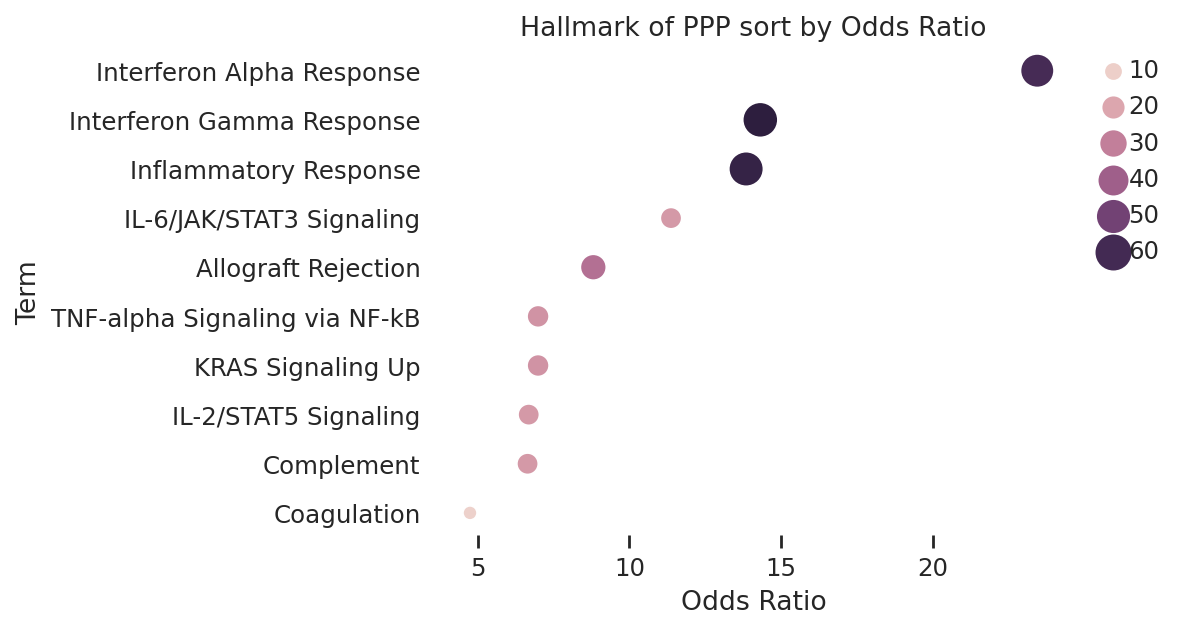

In [19]:
sc.tl.rank_genes_groups(adata_ker, 'Meta', method='wilcoxon', n_genes=8000, use_raw=True, groups=['Lesion'], reference='Control', tie_correct=True)
# gene_list = list(adata_ker.uns['rank_genes_groups']['names']['Lesion'])
gene_list = list(sc.get.rank_genes_groups_df(adata_ker, group='Lesion', key='rank_genes_groups', pval_cutoff=1e-5, log2fc_min=1.5).names)

up_enr_bg = gp.enrichr(gene_list=gene_list,
                 gene_sets=['MSigDB_Hallmark_2020'],
                 organism='human',
                 outdir=None, # don't write to disk
                )

up_enr_bg.results = up_enr_bg.results.sort_values(by='Odds Ratio', ascending=False)
up_enr_bg.results

sns.set_theme(style="white")
up_enr_bg.results['plot_size'] = -np.log(up_enr_bg.results['Adjusted P-value'])

with plt.rc_context({'figure.figsize': (5, 4)}):
    ax = sns.scatterplot(data=up_enr_bg.results.head(10), y='Term', x='Odds Ratio', size='plot_size', sizes=(40, 250), hue='plot_size')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
    ax.xaxis.set_ticks_position('bottom')
    plt.title('Hallmark of PPP sort by Odds Ratio')
    sns.despine(left=True, bottom=True)
    plt.savefig('figures/fig2_5/Hallmark_of_PPP_sort_by_Odds_Ratio.pdf', bbox_inches='tight')

### Matrixplot of IL6-genes

Storing dendrogram info using `.uns['dendrogram_leiden']`


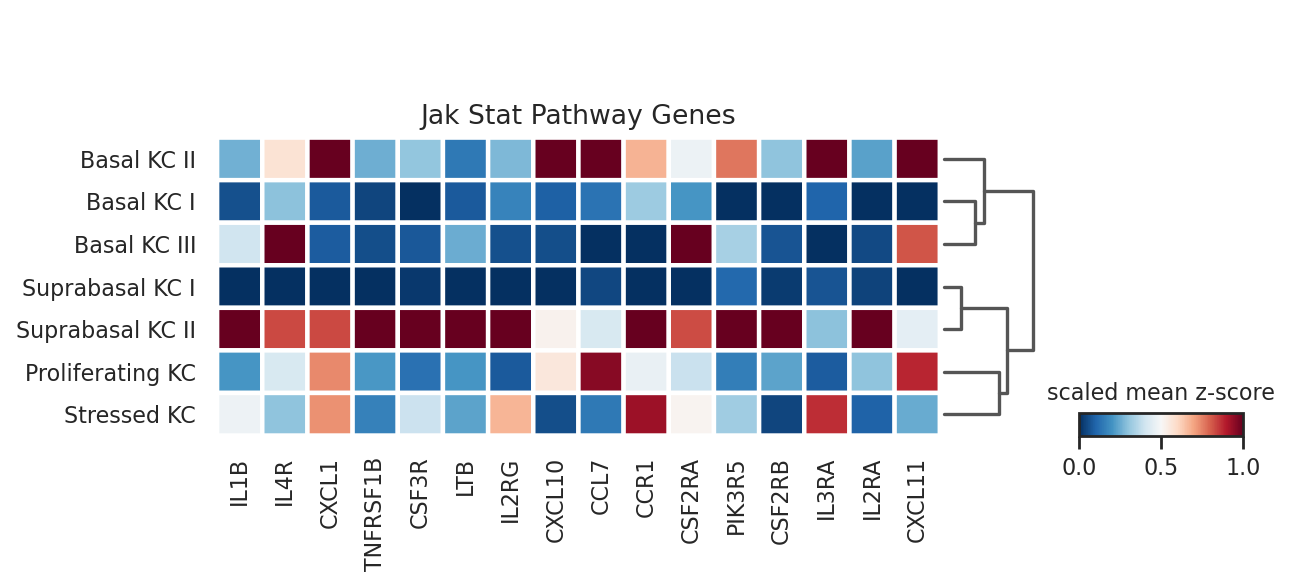

In [12]:
up_enr_bg.res2d[up_enr_bg.res2d.Term == 'IL-6/JAK/STAT3 Signaling'].Genes

jak_stat_gene_list = up_enr_bg.res2d[up_enr_bg.res2d.Term == 'IL-6/JAK/STAT3 Signaling'].Genes.iloc[0].split(';')
jak_stat_gene_list = [x for x in gene_list if x in jak_stat_gene_list]

sc.tl.dendrogram(adata_ker, groupby='leiden', n_pcs=30, use_rep='X_pca')

with plt.rc_context({'figure.figsize': (12, 6)}):
    ax = sc.pl.matrixplot(adata_ker, jak_stat_gene_list[:20], 'leiden', dendrogram=True, use_raw=True, return_fig=True,
                    standard_scale='var', colorbar_title='scaled mean z-score', show=False, linewidths=0.1).style(cmap='RdBu_r', edge_color='white', edge_lw=2).get_axes()
    ax['mainplot_ax'].set_title('Jak Stat Pathway Genes')
    # remove edge 
    ax['mainplot_ax']
    ax['mainplot_ax'].spines['left'].set_visible(False)
    ax['mainplot_ax'].spines['bottom'].set_visible(False)
    ax['mainplot_ax'].spines['top'].set_visible(False)
    ax['mainplot_ax'].spines['right'].set_visible(False)
    plt.savefig('figures/fig2_5/Jak_Stat_Pathway_Genes.pdf', bbox_inches='tight')

### Down enrichment

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:49)


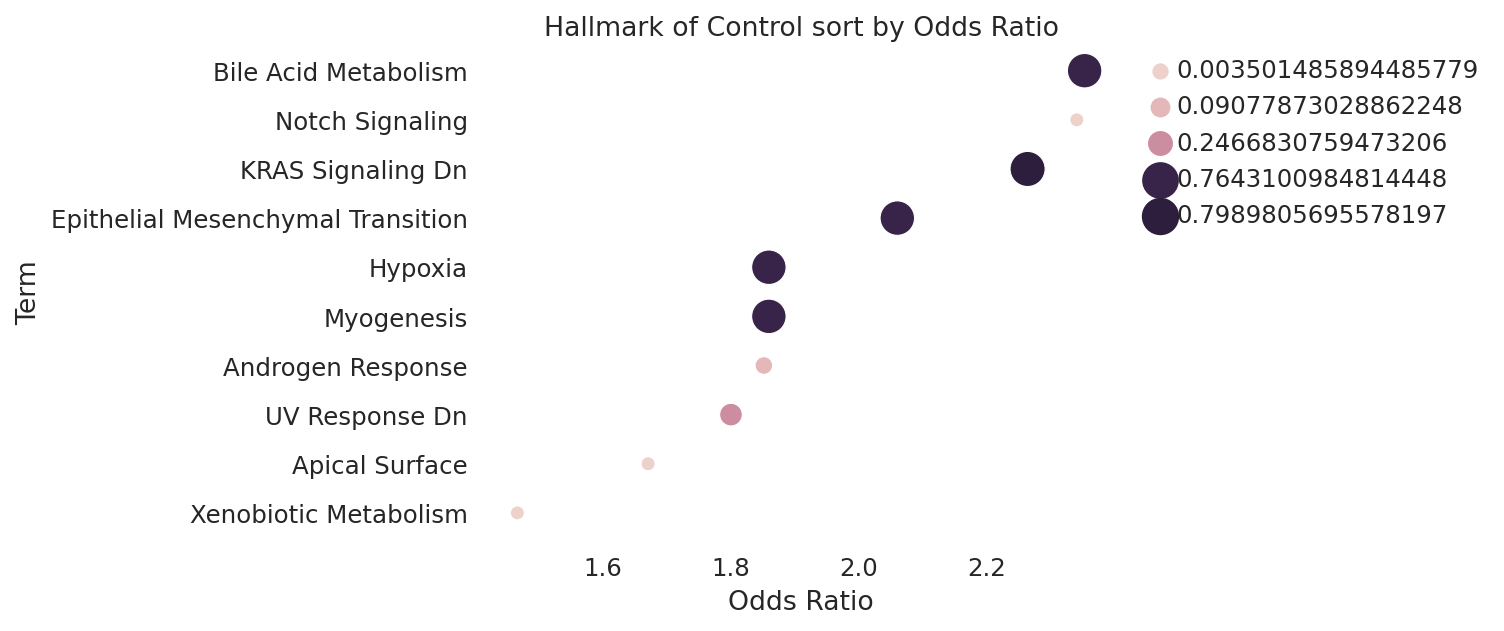

In [20]:
# down
sc.tl.rank_genes_groups(adata_ker, 'Meta', method='wilcoxon', n_genes=8000, use_raw=True, groups=['Control'], reference='Lesion', tie_correct=True)
# gene_list = list(adata_ker.uns['rank_genes_groups']['names']['Lesion'])
gene_list = list(sc.get.rank_genes_groups_df(adata_ker, group='Control', key='rank_genes_groups', pval_cutoff=1e-4, log2fc_min=1).names)

down_enr_bg = gp.enrichr(gene_list=gene_list,
                    gene_sets=['MSigDB_Hallmark_2020'],
                    organism='human',
                    outdir=None, # don't write to disk
                    )

down_enr_bg.results = down_enr_bg.results.sort_values(by='Odds Ratio', ascending=False)
down_enr_bg.results

down_enr_bg.results['plot_size'] = -np.log(down_enr_bg.results['Adjusted P-value'])
# down_enr_bg.results['plot_size'] = down_enr_bg.results['plot_size'].astype(int)

with plt.rc_context({'figure.figsize': (5, 4)}):
    sns.scatterplot(data=down_enr_bg.results.head(10), y='Term', x='Odds Ratio', size='plot_size',sizes=(40, 250), hue='plot_size')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
    plt.title('Hallmark of Control sort by Odds Ratio')
    sns.despine(left=True, bottom=True)
    # plt.savefig('figures/fig2_5/Hallmark_of_Control_sort_by_Odds_Ratio.pdf', bbox_inches='tight')

### IPA results

In [21]:
sc.tl.rank_genes_groups(adata_ker, 'Meta', method='wilcoxon', n_genes=8000, use_raw=True, groups=['Lesion'], reference='Control', tie_correct=True)
df_ipa = sc.get.rank_genes_groups_df(adata_ker, group='Lesion', key='rank_genes_groups', pval_cutoff=1e-5, log2fc_min=1.5)
df_ipa[['names', 'logfoldchanges', 'pvals', 'pvals_adj']].to_csv('charts/DEG_Lesion_vs_Control.tsv', sep='\t', index=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:48)


In [22]:
df_ipa

,names,scores,logfoldchanges,pvals,pvals_adj
0,S100A9,110.463028,5.802470,0.000000,0.000000
1,S100A8,109.789070,5.550132,0.000000,0.000000
2,IFI27,86.133858,5.167297,0.000000,0.000000
3,S100A7,84.821953,4.681950,0.000000,0.000000
4,KRT6A,76.524559,3.033345,0.000000,0.000000
...,...,...,...,...,...
398,C3AR1,4.777986,3.916234,0.000002,0.000005
399,IL36RN,4.776287,1.691847,0.000002,0.000005
400,GPRIN3,4.727298,2.182974,0.000002,0.000006
401,RP11-519G16.3,4.714579,3.304126,0.000002,0.000007


running ipa ...

In [23]:
#TODO: IPA
df_ipa_result = pd.read_csv('/home/wu/datb1/reseq_ppp/Pub_PPP_code/charts/IPA_cytokine_kc_upstream.txt', sep='\t', skiprows=2)
df_ipa_result['Activation z-score'] = df_ipa_result['Activation z-score'].replace(' ', np.nan)
df_ipa_result['Activation z-score'] = df_ipa_result['Activation z-score'].astype(float)
df_ipa_result.dropna(subset=['Activation z-score'], inplace=True)

In [24]:
# get hex code
ipa_palette = sns.palettes.color_palette('tab20').as_hex()
df_ipa_result['color'] = ipa_palette[7]
df_ipa_result.loc[df_ipa_result['Activation z-score'] < 0, 'color'] = ipa_palette[1]
df_ipa_result.loc[df_ipa_result['Upstream Regulator'] == 'OSM', 'color'] = ipa_palette[2]
df_ipa_result_plot = pd.concat([df_ipa_result.sort_values(by='Activation z-score', ascending=False).head(10), df_ipa_result.sort_values(by='Activation z-score', ascending=False).tail(5)])

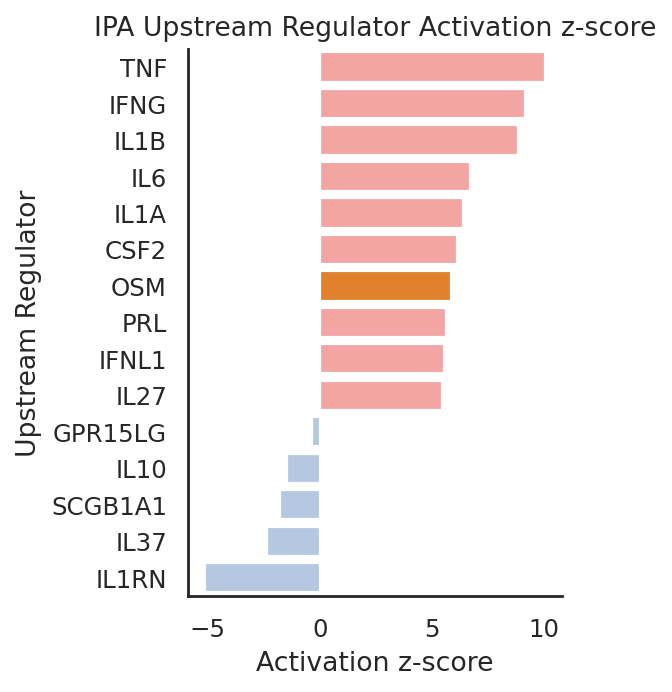

In [25]:
with plt.rc_context({'figure.figsize': (3, 4.5)}):
    sns.barplot(data=df_ipa_result_plot, y='Upstream Regulator', x='Activation z-score', palette=df_ipa_result_plot['color'])
    plt.title('IPA Upstream Regulator Activation z-score')
    sns.despine()
    plt.savefig('figures/fig2_5/IPA_Upstream_Regulator_Activation_z-score.pdf', bbox_inches='tight')
    plt.show()